## Evaluating Clusterings

Evaluating clusterings is a challenging and highly subjective tasks.  In most cases, there is no "true" clustering, and so cluster evaluation is necessarily and *exploratory* process. 

Perhaps the most important thing to consider in evaluating clustering is the role of domain knowledge when interpreting clusters. The 'best' number of clusters according to data-driven metrics may not be meaningful for the problem you're trying to solve; oftentimes, varying the number of clustering is a diagnostic tool that will help you get a little closer to understanding your data.

The next most important thing to remember is the value of visualization - especially when clustering, visual inspection can help you understand not only the performance of clustering, but what sorts of clustering techniques are going to be useful.

In the following, we introduce a variety of different techniques for interpreting and examining clusters.


### K-Means and the Elbow Method

To select the best model in K-means (the right number of $ k $), we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. Instead, we use a "cost function," which we seek to minimize. In $ k $-means\, the typical cost function used is the "within-cluster sum of squares" (WCSS) (also sometimes referred to as `inertia`). Formally, the WCSS is defined as:

$$\text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$$

Where:
- $ k $ is the number of clusters.
- $ C_i $ represents the $ i^{th}$ cluster.
- $ x $ is a data point in cluster $ C_i $
- $ \mu_i $ is the centroid of cluster $ C_i $.
- $ ||x - \mu_i||^2 $ is the squared Euclidean distance between the data point $ x $ and the centroid $ \mu_i $.

The goal of $ k $-means is to assign data points to clusters in a way that the total squared distance between the data points and their corresponding cluster centroids is minimized.

In simpler terms, the cost function measures the compactness of the clustering. A smaller WCSS indicates that the data points are closer to the centroids of their respective clusters, implying a more compact clustering.

In sklearn, the WCSS is referred to as inertia, and accessed via an attribute:

In [ ]:
kmeans.inertia_

211.59853725816836

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [ ]:
# extra code
X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

211.59853725816856

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [ ]:
kmeans.score(X)

-211.5985372581684

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

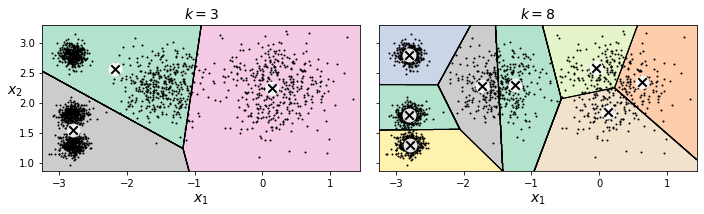

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [ ]:
kmeans_k3.inertia_

653.2167190021554

In [ ]:
kmeans_k8.inertia_

119.11983416102882

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

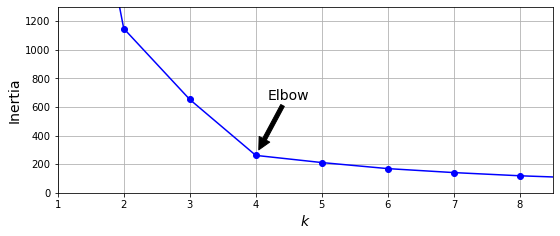

In [ ]:
# extra code – this cell generates and saves Figure 9–8

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

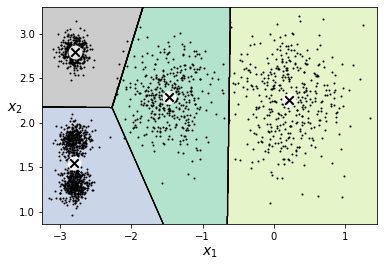

In [ ]:
# extra code
plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

This approach to picking $ k $ is known by its technical name: the **elbow method**.  However, the elbow method does not always yeild a very distinct elbow, especially when the data is somewhat noisy.

### Exercise

Use the elbow method to obtain the best clustering for the iris data.  Does your answer match what you determined previously?

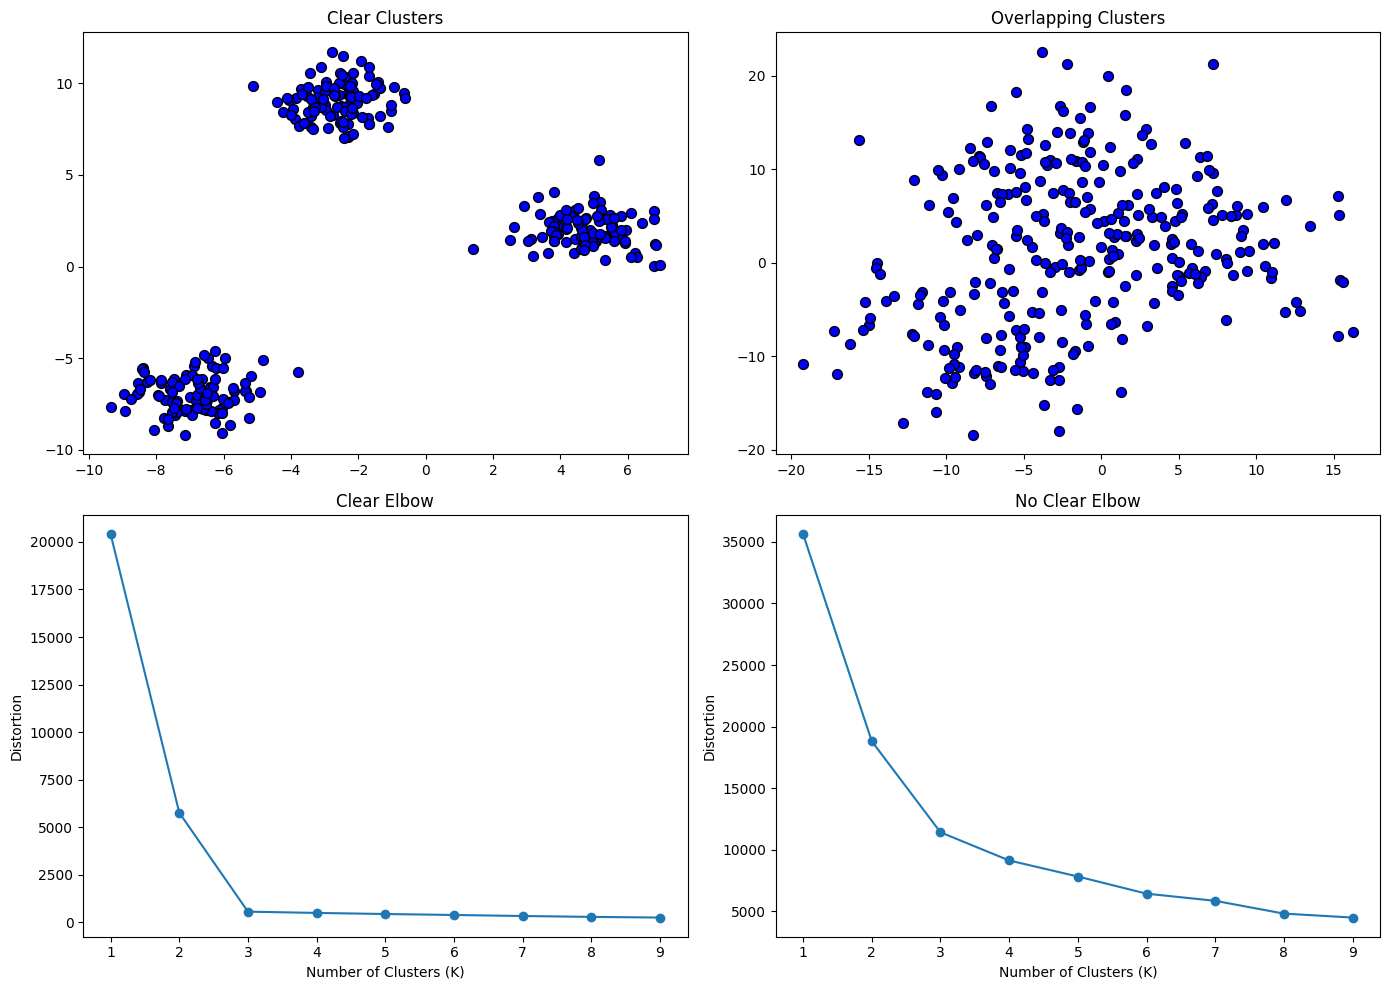

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate synthetic data with 3 clear clusters
X1, y1 = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=1.0)

# Generate synthetic data with no clear clusters (high standard deviation)
X2, y2 = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=5)

# Function to apply KMeans and plot elbow graph
def plot_elbow(ax, X, title):
    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k,n_init='auto')
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    ax.plot(K, distortions, marker='o')
    ax.set_title(title)
    ax.set_xlabel('Number of Clusters (K)')
    ax.set_ylabel('Distortion')

# Function to plot data
def plot_data(ax, X, title):
    ax.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='black', s=50)
    ax.set_title(title)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot data and elbow graphs
plot_data(axes[0, 0], X1, 'Clear Clusters')
plot_data(axes[0, 1], X2, 'Overlapping Clusters')
plot_elbow(axes[1, 0], X1, 'Clear Elbow')
plot_elbow(axes[1, 1], X2, 'No Clear Elbow')

plt.tight_layout()
plt.show()

Because it is highly subjective, it's generally advised to use several different methods for evaluating clustering.

### Silhouette Method


$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

- $ a(i) $ = Average distance from the $ i^{th} $ point to the other points in the same cluster.
- $ b(i) $ = Lowest average distance from the $ i^{th} $ point to the points in the other clusters, minimized over clusters.


1. **Run Clustering**: Perform clustering for your chosen number of clusters $ k $.
   
2. **Calculate Silhouette Scores**: Compute the silhouette score for each data point using the formula.

3. **Plot Silhouette Values**: Create a silhouette plot to visualize how close each point in one cluster is to the points in the neighboring clusters.

4. **Interpret Results**: 
    - A high average silhouette width indicates a good clustering.
    - Silhouette scores range from -1 for incorrect clustering to +1 for highly dense clustering. 

#### Limitations

- Computationally expensive for large datasets.
- May not be suitable for non-convex clusters.



#### Plotting silhouette scores

We can inspect silhouette scores using a "silhouette plot" or, as with the elbow method, plotting a mean silhouette score for different values of k. 

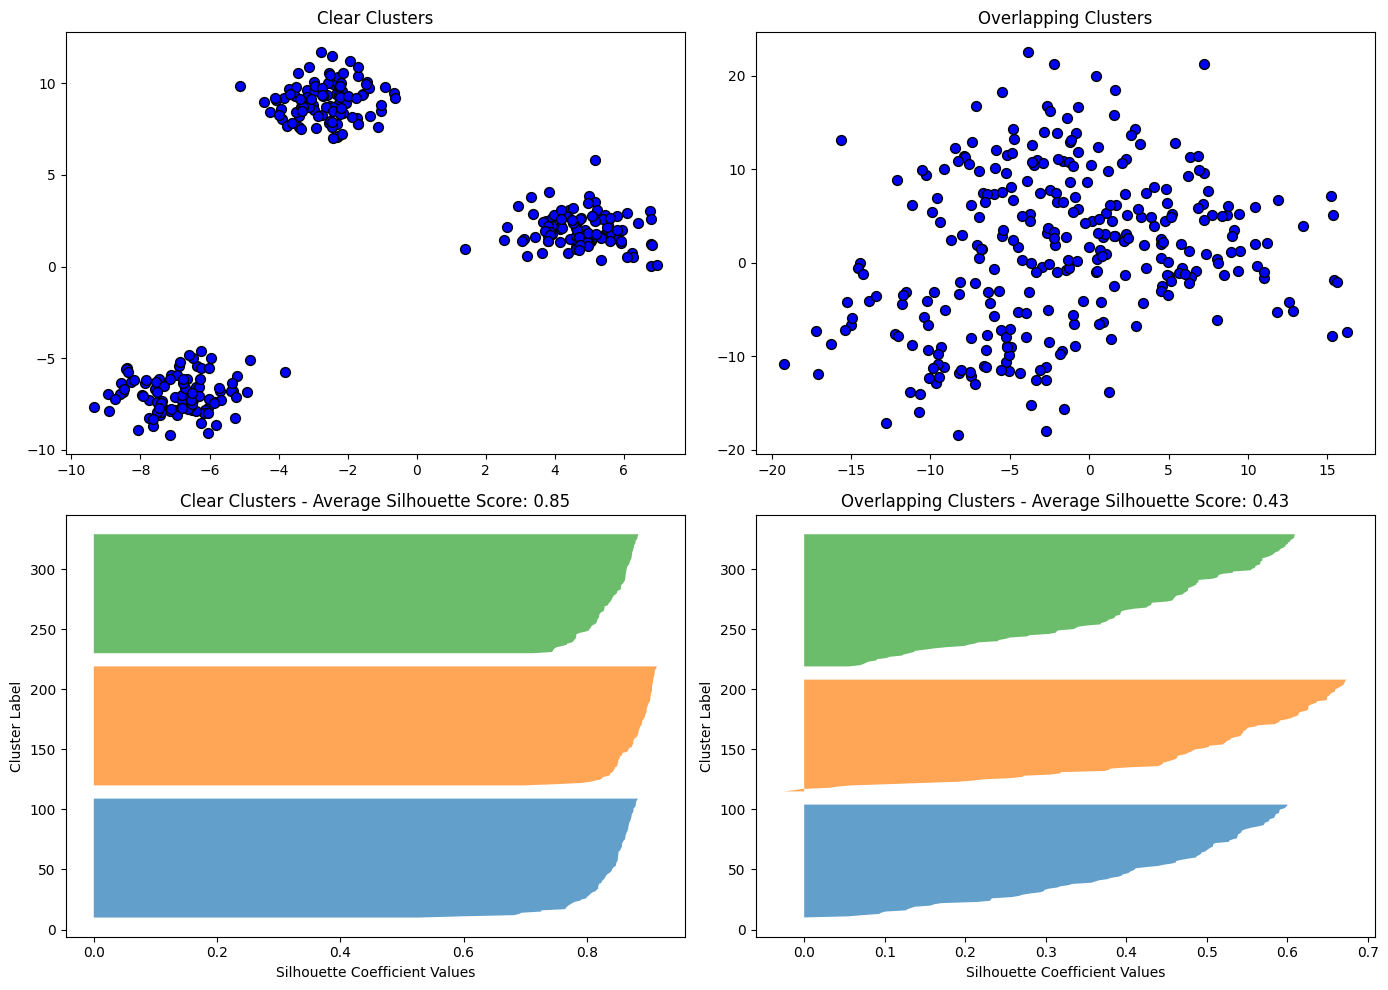

In [9]:
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

# Function to apply KMeans and plot silhouette graph
def plot_silhouette(ax, X, title):
    # List to store average silhouette scores for different number of clusters
    avg_silhouette_scores = []
    K = [3]  # Start from 2 as silhouette score requires at least 2 clusters
    
    for k in K:
        kmeans = KMeans(n_clusters=k,n_init='auto')
        cluster_labels = kmeans.fit_predict(X)
        
        # Calculate the silhouette score for the current number of clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        avg_silhouette_scores.append(silhouette_avg)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        # Plot silhouette scores for each cluster
        y_lower = 10  # For space between silhouette plots of individual clusters
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)
            y_lower = y_upper + 10

    ax.set_title(f"{title} - Average Silhouette Score: {silhouette_avg:.2f}")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot data and silhouette graphs
plot_data(axes[0, 0], X1, 'Clear Clusters')
plot_data(axes[0, 1], X2, 'Overlapping Clusters')
plot_silhouette(axes[1, 0], X1, 'Clear Clusters')
plot_silhouette(axes[1, 1], X2, 'Overlapping Clusters')

plt.tight_layout()
plt.show()

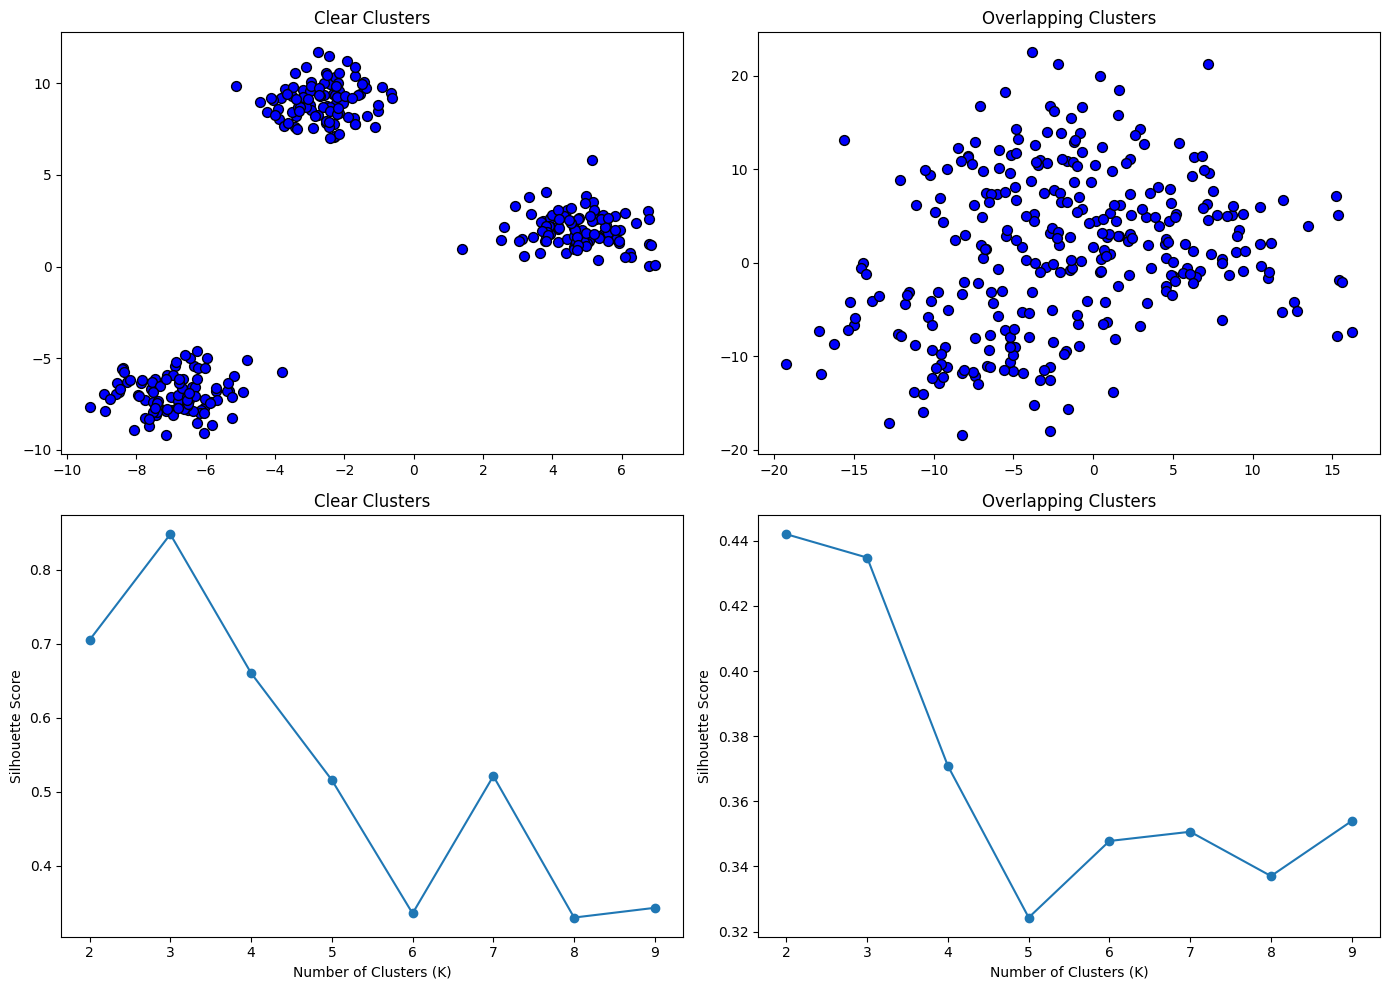

In [8]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Generate synthetic data with 3 clear clusters
X1, y1 = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=1.0)

# Generate synthetic data with no clear clusters (high standard deviation)
X2, y2 = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=5)

# Function to apply KMeans and plot silhouette scores
def plot_silhouette(ax, X, title):
    silhouette_scores = []
    K = range(2, 10)  # silhouette_score requires at least 2 clusters
    for k in K:
        kmeans = KMeans(n_clusters=k,n_init='auto')
        kmeans.fit(X)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    ax.plot(K, silhouette_scores, marker='o')
    ax.set_title(title)
    ax.set_xlabel('Number of Clusters (K)')
    ax.set_ylabel('Silhouette Score')

# Function to plot data
def plot_data(ax, X, title):
    ax.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='black', s=50)
    ax.set_title(title)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot data and silhouette graphs
plot_data(axes[0, 0], X1, 'Clear Clusters')
plot_data(axes[0, 1], X2, 'Overlapping Clusters')
plot_silhouette(axes[1, 0], X1, 'Clear Clusters')
plot_silhouette(axes[1, 1], X2, 'Overlapping Clusters')

plt.tight_layout()
plt.show()

### Davies-Bouldin method

Certainly, the Davies-Bouldin Index is another metric used to evaluate the quality of a clustering algorithm. Unlike the Silhouette Score, lower values of the Davies-Bouldin Index indicate better clustering.

#### Calculation

1. **Within-cluster Distance**: For each cluster, calculate the average distance of each point in the cluster to the centroid of that cluster. This is denoted as $ S_i $ for cluster $ i $.

    $$
    S_i = \frac{1}{n_i} \sum_{j=1}^{n_i} d(x_j, c_i)
    $$

    Here, $ n_i $ is the number of points in cluster $ i $, $ x_j $ is a point in cluster $ i $, and $ c_i $ is the centroid of cluster $ i $.

2. **Between-cluster Distance**: For each pair of clusters $ i $ and $ j $, calculate the distance between their centroids $ c_i $ and $ c_j $. This is denoted as $ d(c_i, c_j) $.

3. **Davies-Bouldin value for a Pair**: For each pair of clusters $ i $ and $ j $, calculate the Davies-Bouldin value $ R_{ij} $ using the formula:

    $$
    R_{ij} = \frac{S_i + S_j}{d(c_i, c_j)}
    $$

4. **Maximal Davies-Bouldin value for Each Cluster**: For each cluster $ i $, find the cluster $ j $ that maximizes $ R_{ij} $. Let this maximum value for cluster $ i $ be $ R_i $.

    $$
    R_i = \max_{j \neq i} R_{ij}
    $$

5. **Average over All Clusters**: Finally, the Davies-Bouldin Index $ DB $ is the average of $ R_i $ over all clusters.

    $$
    DB = \frac{1}{k} \sum_{i=1}^{k} R_i
    $$

Here, $ k $ is the number of clusters.


#### Limitations and Benefits

- **Benefits**: The Davies-Bouldin Index is simple to understand and computationally efficient.
  
- **Limitations**: It may sometimes favor convex clusters over other types.

Would you like to see a Python code example illustrating how to use the Davies-Bouldin Index for evaluation?

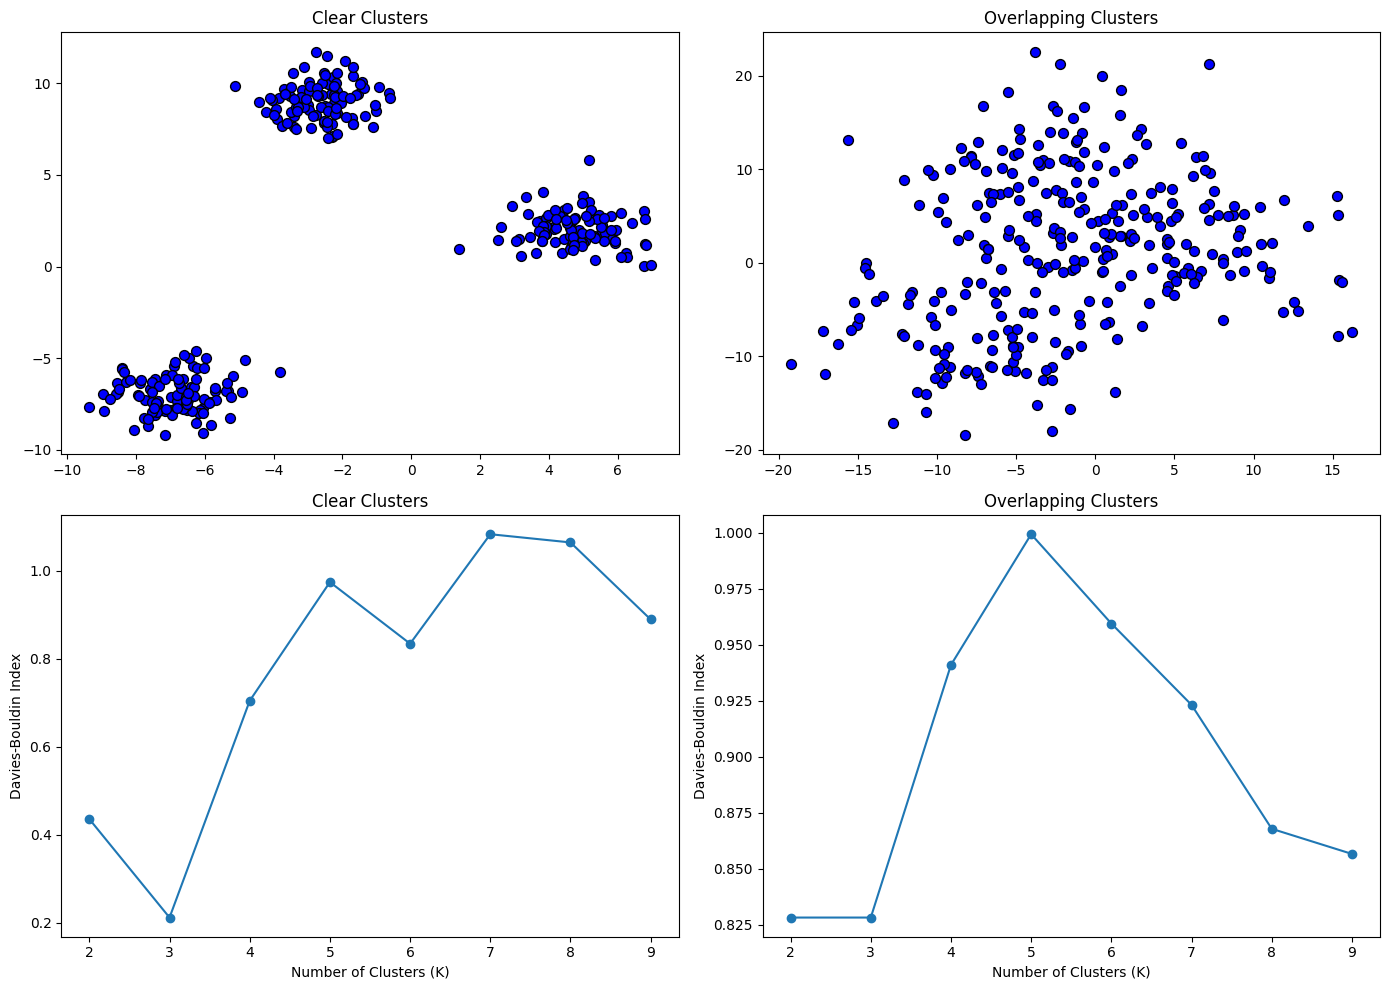

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Generate synthetic data with 3 clear clusters
X1, y1 = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=1.0)

# Generate synthetic data with no clear clusters (high standard deviation)
X2, y2 = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=5)

# Function to apply KMeans and plot silhouette scores
def plot_davies_bouldin(ax, X, title):
    db_scores = []
    K = range(2, 10)  # Davies-Bouldin is undefined for n_clusters=1
    for k in K:
        kmeans = KMeans(n_clusters=k,n_init='auto')
        kmeans.fit(X)
        labels = kmeans.labels_
        db_score = davies_bouldin_score(X, labels)
        db_scores.append(db_score)
    
    ax.plot(K, db_scores, marker='o')
    ax.set_title(title)
    ax.set_xlabel('Number of Clusters (K)')
    ax.set_ylabel('Davies-Bouldin Index')

# Function to plot data
def plot_data(ax, X, title):
    ax.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='black', s=50)
    ax.set_title(title)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot data and silhouette graphs
plot_data(axes[0, 0], X1, 'Clear Clusters')
plot_data(axes[0, 1], X2, 'Overlapping Clusters')
plot_davies_bouldin(axes[1, 0], X1, 'Clear Clusters')
plot_davies_bouldin(axes[1, 1], X2, 'Overlapping Clusters')

plt.tight_layout()
plt.show()

### Exercise

Using the data in the data directory, use the data driven clustering methods to decide on the best clustering number. What do you come up with?

### Visual Inspection

As discussed above, you should **always** strive to visualize your data. However, for data with more than three dimensions, we cannot directly plot the clusters for visual inspection. Dimensionality reduction techniques like PCA and t-SNE can help.

1. **PCA (Principal Component Analysis)**: 
    - Linear technique
    - Preserves global data structure
    - Fast and works well for high-dimensional data
    - May not capture complex relationships between features

2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
    - Non-linear technique
    - Preserves local data structure
    - Computationally intensive
    - Good for capturing complex relationships but may introduce artifacts

#### Best Practices:

1. **Standardization**: Always standardize your data before applying dimensionality reduction techniques.

2. **Multiple Views**: Use multiple methods for dimensionality reduction to get different views of the data.

3. **Color Code**: Use color coding to differentiate between clusters and to compare them against known labels, if available.

4. **Pair with Metrics**: Always use visual inspection in conjunction with other evaluation metrics for a more robust assessment.

#### Limitations:

1. **Misleading Interpretations**: Dimensionality reduction can sometimes simplify the data too much, leading to incorrect interpretations.
  
2. **Computational Cost**: Some methods, like t-SNE, are computationally expensive.

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Generate synthetic data with 3 clusters in 10 dimensions
X, y = make_blobs(n_samples=300, centers=3, n_features=10, random_state=42, cluster_std=1.0)
pd.DataFrame(X).head(5)

,0,1,2,3,4,5,6,7,8,9
0,-8.555764,10.524902,5.557886,-6.164032,-7.469205,-6.546831,-4.223189,1.274789,-0.050791,-2.779733
1,-1.351087,9.805949,5.263999,2.601515,-6.891874,-7.777364,-8.762523,6.646361,2.997420,4.014394
2,-8.969156,11.455693,6.669647,-6.481221,-6.546397,-4.957033,-4.561119,-0.304063,-1.843843,-5.128746
3,-3.101592,8.150295,4.688400,1.142220,-6.609170,-6.930348,-9.077276,6.415959,1.445529,4.916843
4,1.336437,-6.571731,-4.485726,-2.069576,-1.422714,5.540726,-5.965605,-0.717499,2.589116,-9.584205


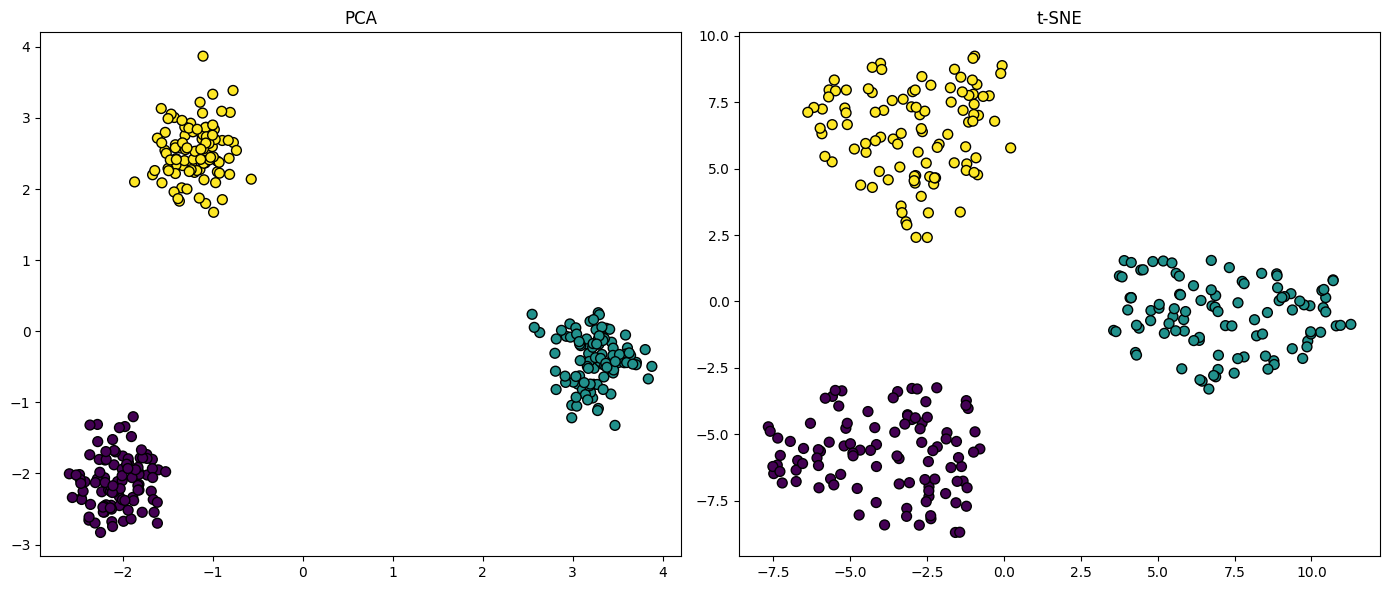

In [12]:
# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3,n_init='auto')
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot original data in 2D PCA space
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, marker='o', edgecolor='black', s=50)
axes[0].set_title('PCA')

# Plot original data in 2D t-SNE space
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, marker='o', edgecolor='black', s=50)
axes[1].set_title('t-SNE')

plt.tight_layout()
plt.show()

### Exercise

Use PCA and t-SNE to visualize the sample_data.  What do you see?  Does it help you understand your clustering performance?

### Cluster exploration and Stability Analysis

Another potentially valuable technique for investigating different clusterings with a given method is called *stability analysis*.  Stability analysis assesses how consistently a clustering algorithm groups the same or similar data points into the same clusters across different runs. Stability analysis often involves bootstrapping or perturbing the dataset and then applying the clustering algorithm multiple times, but can be used to compare the cluster assignments across different parameter settings.

#### Best Practices:

1. **Multiple Runs**: Conduct multiple runs with different initial conditions or subsets of the data.
  
2. **Consensus Clustering**: Use consensus clustering to combine the results of multiple runs into a single clustering that captures the stable structure in the data.

3. **Parameter Sensitivity**: Stability analysis can also be used to assess the sensitivity of the clustering to parameter choices.

#### Limitations:

1. **Computationally Intensive**: Stability analysis requires multiple runs of the clustering algorithm, which can be computationally expensive.

2. **False Positives**: Stable clusters are not necessarily meaningful clusters. They might capture noise in a stable way.

#### When to Use:

- When you have high-dimensional data or complex data structures.
- When you're unsure about the reliability of the clustering.
- When you're comparing the performance of different clustering algorithms or parameter settings.
- When you're assessing the relative "clusterability" of different data points.

#### Approach
- **General idea**: calculate cluster assignments over multiple instances and then compare adjacent clusterings.  
- When instances follow an original parameter range, looking for a “plateau” can help identify a decent parameter range

To compare adjacent clusterings, one technique is to use the **Adjusted Rand Index**.

#### Adjusted Rand Index (ARI)

The Adjusted Rand Index is a general measure of the similarity between two data clusterings, adjusted for chance.  It is not necessary for different clusterings to have the same labels, or even the same number of clusters.

- ARI = 1: Perfect match
- ARI > .65: Marginally acceptable
- ARI = 0: Random clustering
- ARI < 0: Poor clustering

Note that it is possible to calculate a p\-value for ARI\, as follows:
  * __Compute the ARI for your actual data__ : This will be the value you're testing for significance\.
  * __Random Permutations__ : Shuffle the labels of one of the two clusterings \(either true or predicted\) randomly\, while keeping the other clustering fixed\. Compute the ARI for each of these permuted sets\.
  * __Generate a Null Distribution__ : Repeat step 2 a large number of times \(e\.g\.\, 1000 or 10\,000 times\) to generate a distribution of ARI scores that you would expect to see purely by chance\.
  * __Calculate p\-value__ : The p\-value is the proportion of permuted ARIs that are greater than or equal to the observed ARI\. A small p\-value indicates that the observed ARI is significantly different from what would be expected by random chance\, thus suggesting that the clustering is meaningful\.



In [13]:
from sklearn.metrics import adjusted_rand_score
import numpy as np

def perm_test_ari(true_labels, pred_labels, n_perm=1000):
    actual_ari = adjusted_rand_score(true_labels, pred_labels)
    perm_ari = []
    
    for i in range(n_perm):
        perm_labels = np.random.permutation(pred_labels)
        perm_ari.append(adjusted_rand_score(true_labels, perm_labels))
        
    p_value = (np.sum(np.array(perm_ari) >= actual_ari) + 1) / (n_perm + 1)
    
    return actual_ari, p_value

# Example usage
true_labels = [0, 0, 1, 1, 2, 2]
pred_labels = [0, 0, 1, 2, 2, 2]  # some clustering result

actual_ari, p_value = perm_test_ari(true_labels, pred_labels)

print(f"Actual ARI: {actual_ari}")
print(f"P-value: {p_value}")

Actual ARI: 0.4444444444444444
P-value: 0.1998001998001998


### Stability Analysis with ARI

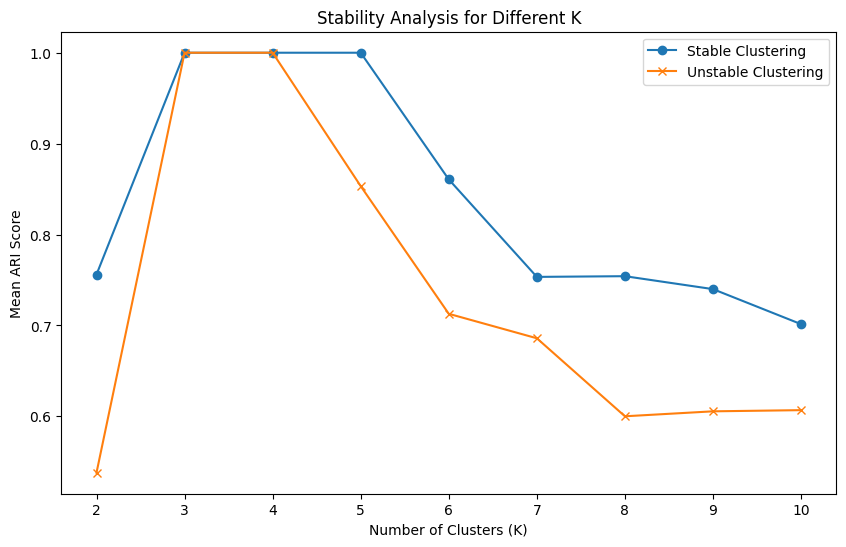

In [14]:
import matplotlib.pyplot as plt


def create_data(centers, std_dev):
    X, y = make_blobs(n_samples=300, centers=centers, cluster_std=std_dev, random_state=42)
    return X

# Function to run KMeans with different K and check stability
def check_stability_for_diff_K(X, K_values, n_runs=5):
    ari_scores = []
    
    for k in K_values:
        temp_ari_scores = []
        prev_labels = None
        
        for i in range(n_runs):
            kmeans = KMeans(n_clusters=k, random_state=i, n_init="auto")
            kmeans.fit(X)
            labels = kmeans.labels_

            if prev_labels is not None:
                ari = adjusted_rand_score(prev_labels, labels)
                temp_ari_scores.append(ari)
            
            prev_labels = labels
        
        mean_ari = np.mean(temp_ari_scores)
        ari_scores.append(mean_ari)
    
    return ari_scores

# K values to test
K_values = range(2, 11)

X_stable = create_data(centers=5, std_dev=1.0)
X_unstable = create_data(centers=5, std_dev=2.0)

# Check stability for different K
stable_scores = check_stability_for_diff_K(X_stable, K_values)
unstable_scores = check_stability_for_diff_K(X_unstable, K_values)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(K_values, stable_scores, marker='o', label='Stable Clustering')
plt.plot(K_values, unstable_scores, marker='x', label='Unstable Clustering')
plt.title('Stability Analysis for Different K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Mean ARI Score')
plt.legend()
plt.show()